In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from smstools.models import utilFunctions as UF
from smstools.models import hprModel as HPR
from smstools.models import stft as STFT

In [309]:
#inputFile = '/Users/dpwe/Downloads/M1_Piano_C3.wav'
inputFile = '/Users/dpwe/Downloads/track02-C4.wav'
window = 'hamming'
M = 1001
N = 1024
t = -100
minSineDur = 0.1
nH = 100
minf0 = 100
maxf0 = 700
f0et = 5
harmDevSlope = 0.1
H = 128
fs, x = UF.wavread(inputFile)


In [310]:
w = scipy.signal.get_window(window, M)

In [311]:
hfreq, hmag, hphase, xr = HPR.hprModelAnal(x, fs, w, N, H, t, minSineDur, nH, minf0, maxf0, f0et, harmDevSlope)


In [317]:
print(hmag.shape)
for h in range(10):
    initialzeros = 1 + min(np.flatnonzero(hmag[1:, h] != 0))
    print(h, initialzeros)

(1498, 100)
0 26
1 26
2 26
3 26
4 26
5 26
6 26
7 26
8 26
9 26


In [322]:
start_frame = 1 + min(np.flatnonzero(hmag[1:, 0] != 0))
hfreq = hfreq[start_frame:, :]
hmag = hmag[start_frame:, :]
hphase = hphase[start_frame:, :]
xr = xr[start_frame * H:]

In [323]:
frmTime = H * np.arange(hfreq.shape[0]) / fs
print(H/fs)

0.0029024943310657597


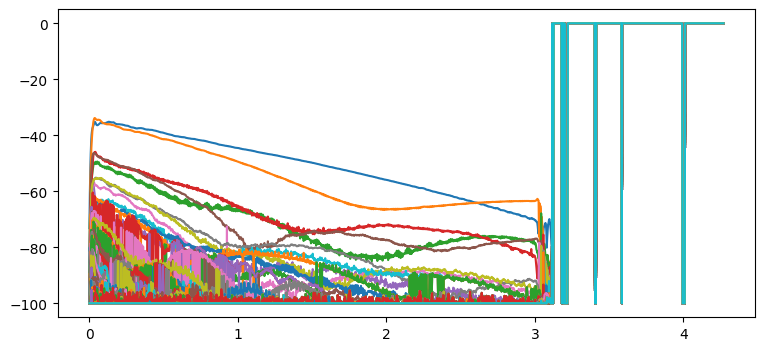

In [324]:
plt.figure(figsize=(9,4))

_ = plt.plot(frmTime, hmag)

[-35.87356989 -35.75437815 -35.63138572 -35.59504185 -35.55262465
 -35.66215248 -35.70126739]


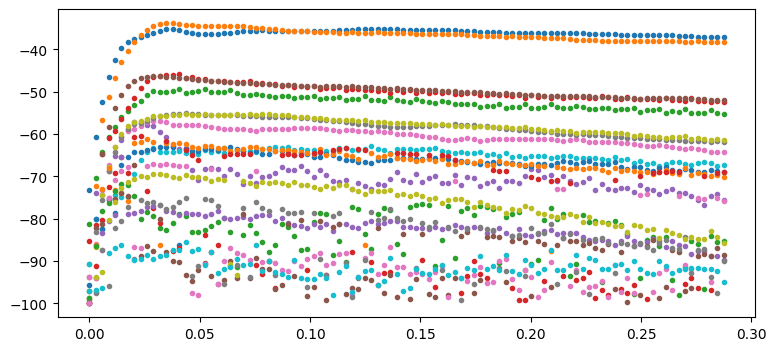

In [325]:
plt.figure(figsize=(9,4))
nfrm = 100
harms = np.arange(20)
_ = plt.plot(frmTime[:nfrm], hmag[:nfrm, harms], '.')
print(hmag[23:30, 0])

[-36.11649069 -36.10783732 -36.01133083 -35.97299792 -35.82352828
 -35.82202464 -35.76556586]


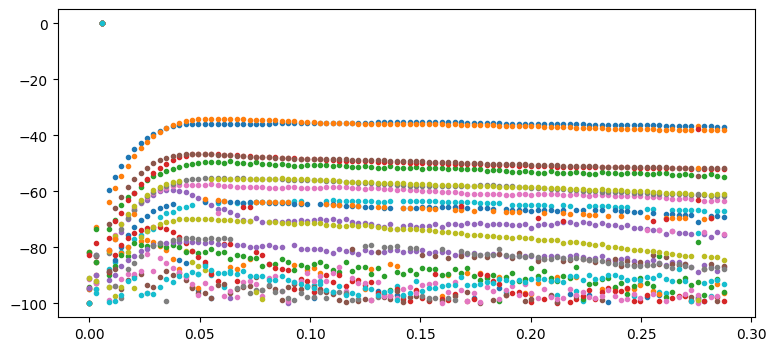

In [305]:
plt.figure(figsize=(9,4))
nfrm = 100
harms = np.arange(20)
_ = plt.plot(frmTime[:nfrm], hmag[:nfrm, harms], '.')
print(hmag[23:30, 0])

gap pts= 13
1 5 -95.6759394757419 -67.29312852125533 [-95.67593948 -89.99937728 -84.32281509 -78.6462529  -72.96969071
 -67.29312852]
14 15 -63.08312297032608 -63.64564259062086 [-63.08312297 -63.36438278 -63.64564259]
385 386 -84.14279598769993 -84.86145226400278 [-84.14279599 -84.50212413 -84.86145226]
539 540 -93.16739575413963 -92.96213625036776 [-93.16739575 -93.064766   -92.96213625]
543 544 -92.84918199222236 -92.84107881666823 [-92.84918199 -92.8451304  -92.84107882]
601 602 -96.02129230774719 -94.59367647879212 [-96.02129231 -95.30748439 -94.59367648]
614 615 -97.03655381632625 -96.27676149098369 [-97.03655382 -96.65665765 -96.27676149]
618 619 -96.49443157880766 -95.49824232942824 [-96.49443158 -95.99633695 -95.49824233]
622 623 -96.0680696584656 -96.3327623756881 [-96.06806966 -96.20041602 -96.33276238]
676 677 -96.6318706913761 -96.58321217258334 [-96.63187069 -96.60754143 -96.58321217]


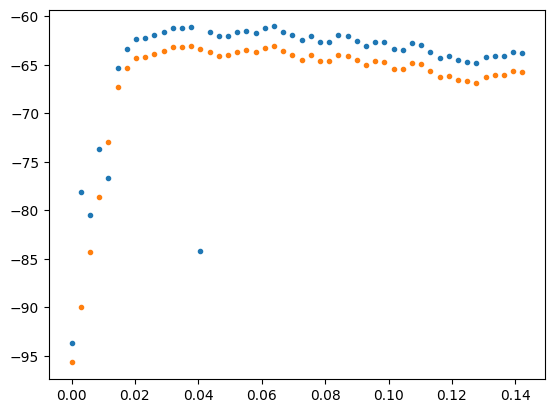

In [345]:
def lin_fit(x):
    """Least-squares linear fit to points."""
    # xhat = a + b.index
    # err = x[i] - (a + b.i)
    # err^2 = x[i]^2 - 2 x[i] (a + b.i) + (a^2 + 2 a b i +b^2 i^2)
    # Define axes around midpoint.
    lenx = len(x)
    if not lenx:
        return []
    index = np.arange(lenx) - (lenx - 1) / 2
    # Make x zero mean
    a = np.mean(x)
    x_z = x - a
    b = 0
    if lenx > 1:
        # Linear fit is normalized inner product
        b = np.sum(x_z * index) / np.sum(index * index)
    return a + b * index

def fit_2_segs(x):
    """Fit x with 2 linear segments, searching all divisions."""
    # Try every poss division of remainder.
    besterr = np.sum(np.abs(x))
    besterrpt = 0
    bestxhat = []
    bestseg1 = []
    bestseg2 = []
    for divpt in np.arange(0, len(x)):
        seg1 = lin_fit(x[:divpt + 1])
        seg2 = lin_fit(x[divpt:])
        xhat = np.hstack([seg1[:-1], seg2])
        abserr = np.sum(np.abs(xhat - x))
        if abserr < besterr:
            besterr = abserr
            besterrpt = divpt
            bestseg1 = seg1
            bestseg2 = seg2
            bestxhat = xhat
    # Parameterization is [value, interval, value interval, value...]
    parameters = [bestseg1[0], len(bestseg1), 0.5 * (bestseg1[-1] + bestseg2[0]), len(bestseg2), bestseg2[-1]]
    #print(bestseg1, bestseg2, parameters)
    #print("parameters=", parameters)
    return bestxhat, parameters

def expand_params(params):
    """Convert [val, npts, val, npts, val] sequence to points."""
    val0 = params[0]
    outpts = [[val0]]
    npts_val_pairs = np.vstack([params[1::2], params[2::2]])
    for npts, val in npts_val_pairs.transpose():
        outpts.append(np.linspace(val0, val, int(npts))[1:])
        val0 = val
    return np.concatenate(outpts)
                    

def median(x):
    npts2 = (len(x) - 1) // 2
    return np.sort(x)[npts2]

def median_filter(x, npts):
    npts2 = (npts - 1) // 2
    padded_x = np.hstack([x[0] * np.ones(npts2), x, x[-1] * np.ones(npts2)])
    y = np.zeros_like(x)
    for i in range(len(x)):
        y[i] = median(padded_x[i : i + npts])
    return y

def linseg_fit(x):
    """Approximate sequence x as a set of line segments."""
    # Start with onset slope
    maxpt = np.argmax(x)
    #print("maxpt=", maxpt)
    initial, i_params = fit_2_segs(x[:maxpt + 1])
    tail, t_params = fit_2_segs(x[maxpt:])
    params = i_params[:-1] + [0.5 * (i_params[-1] + t_params[0])] + t_params[1:]
    #print(initial.shape, tail.shape)
    #print(params)
    return np.hstack([initial, tail[1:]]), expand_params(params), params

def fill_gaps(x):
    """Bridge parts of x that are nan with linear interpolation."""
    gaps = np.isnan(x)
    x_out = np.array(x)
    gap_starts = np.flatnonzero(np.logical_and(gaps, np.hstack([[1], 1 - gaps[:-1]])))
    gap_ends = np.flatnonzero(np.logical_and(1 - np.hstack([gaps, [0]]), np.hstack([[0], gaps])))
    #print(gap_starts, gap_ends)
    for gap_start, gap_end in zip(gap_starts, gap_ends):
        if gap_start == 0:
            start_val = x[gap_end]
        else:
            start_val = x[gap_start - 1]
        if gap_end == len(x):
            end_val = x[gap_start - 1]
        else:
            end_val = x[gap_end]
        fill = np.linspace(start_val, end_val, gap_end - gap_start + 2)
        print(gap_start, gap_end, start_val, end_val, fill)
        x_out[gap_start:gap_end] = fill[1:-1]
    return x_out
    
def mend_gaps(x, threshold=2, filter_len=9):
    """Interpolate portions of x that are too wide."""
    gaps = np.flatnonzero(np.isnan(x))
    x_patched = fill_gaps(x)
    smoothed = median_filter(x_patched, filter_len)
    delta = np.abs(x_patched - smoothed)
    x_patched[np.flatnonzero(delta > threshold)] = np.nan
    x_patched[gaps] = np.nan
    print("gap pts=", np.sum(np.isnan(x_patched)))
    return fill_gaps(x_patched)
    #return smoothed

hnum = 10
analysis_time = 2.0
nfrm = int(analysis_time * fs/H)  # ~300 analysis_time
hh = np.array(hmag[:nfrm, hnum])
hh[np.flatnonzero(hh == 0)] = np.nan
#hh = median_filter(hh, 3)

npts = 50
_ = plt.plot(frmTime[:npts], hh[:npts] + 2, '.', frmTime[:npts], mend_gaps(hh)[:npts], '.')

if False:
    xhat, xhat2, params = linseg_fit(median_filter(hh, 5))
    #print(xhat.shape, xhat2.shape)
    
    plt.figure(figsize=(9, 4))
    _ = plt.plot(frmTime[:nfrm], hh, '.', frmTime[:nfrm], xhat, '.', frmTime[:nfrm], xhat2, '.')
    print(np.sum(np.isnan(hh)))
    maxval = np.max(hh[np.flatnonzero(np.isnan(hh) == 0)])
    print(maxval)
    plt.ylim([maxval - 25, maxval + 5])

In [277]:
x = np.arange(10, dtype=np.float32)
x[2] = np.nan
x[3] = np.nan
x[7] = np.nan
x[9] = np.nan
x[0] = np.nan
print(x[-1])
print(fill_gaps(x))
print(x[1:2], x[4:6])


nan
0 1 1.0 1.0 [1. 1. 1.]
2 4 1.0 4.0 [1. 2. 3. 4.]
7 8 6.0 8.0 [6. 7. 8.]
9 10 8.0 8.0 [8. 8. 8.]
[1. 1. 2. 3. 4. 5. 6. 7. 8. 8.]
[1.] [4. 5.]


In [356]:
# Convert sinusoids into bp sets

SCALEUP = 100.0

def lin_of_db(dbval):
    return SCALEUP * np.exp(np.log(10) * dbval / 20.0)

def db_of_lin(linval):
    return 20.0 * np.log10(linval / SCALEUP)

print(lin_of_db(np.array([0, 10 ,20])))

analysis_time = 2.0
dt = H / fs
nfrm = int(analysis_time / dt)  # 300 * analysis_time

harms_params = {}

max_harmonic = 20

for hnum in range(max_harmonic):
    x = hmag[:nfrm, hnum]
    x[np.flatnonzero(x == 0)] = np.nan
    xhat, xhat2, params = linseg_fit(median_filter(x, 5))
    #print(xhat.shape, xhat2.shape)
    val0 = params[0]
    nvals = zip(params[1::2], params[2::2])
    bp_list = [[0, lin_of_db(params[0])]] + [(int(round(n * dt * 1000)), lin_of_db(val)) for n, val in nvals]
    last_time, last_mag = bp_list[-1]
    last_mag_db = db_of_lin(last_mag)
    final_mag_db = -100.0
    if last_mag_db > final_mag_db:
        terminal_slope = 20.0  # -db/sec
        final_dur = (last_mag_db - final_mag_db) / terminal_slope
        bp_list.append((int(round(1000*final_dur)), lin_of_db(final_mag_db)))
    print("h", hnum + 1, bp_list)
    harms_params[hnum + 1] = bp_list
    

[ 100.          316.22776602 1000.        ]
h 1 [[0, 0.03646117968209008], (17, 1.4790503289019412), (116, 1.7464818747653081), (1364, 0.32805053827525693), (511, 0.1609264966801982), (2207, 0.0009999999999999998)]
h 2 [[0, 0.0012634508047348386], (9, 0.21596971199840045), (32, 2.404807458377003), (729, 0.5502459191358052), (1239, 0.03756845077976835), (1575, 0.0009999999999999998)]
h 3 [[0, 0.01254349241718219], (15, 0.15099185596710532), (26, 0.3421051478156847), (804, 0.051061292632147516), (1164, 0.0047740936634367475), (679, 0.0009999999999999998)]
h 4 [[0, 0.004250878808238577], (9, 0.057457146712061244), (32, 0.5554119700653773), (1434, 0.018122634597003563), (534, 0.025025024003812353), (1398, 0.0009999999999999998)]
h 5 [[0, 0.0009999999999999998], (6, 0.01816626570185348), (20, 0.08438815335232426), (624, 0.006071196966144399), (1358, 0.002903916392093575), (463, 0.0009999999999999998)]
h 6 [[0, 0.002161710338513421], (12, 0.15650724904503518), (20, 0.5925248800917347), (1245

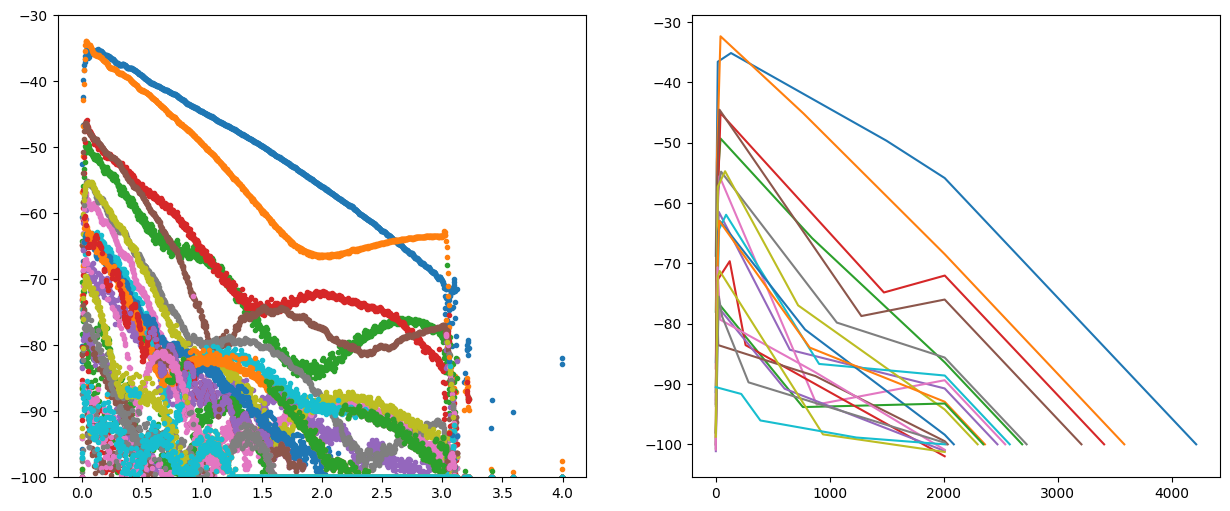

In [362]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
nfrm = int(2 * analysis_time / dt)  # 300 * analysis_time
harms = np.arange(20)
_ = plt.plot(frmTime[:nfrm], hmag[:nfrm, harms], '.')
plt.ylim([-100, -30])

plt.subplot(1,2,2)
for i in range(len(harms_params)):
    hnum = i + 1
    times, vals = zip(*np.array(harms_params[hnum]))
    times = np.cumsum(times)
    vals = np.array(vals)
    plt.plot(times, db_of_lin(vals))

In [358]:
import json
params_file = 'track02-C4-bps.json'
with open(params_file, 'w') as f:
    f.write(json.dumps(harms_params))

In [360]:
#UF.wavwrite(SCALEUP * xr, fs, 'track02-C4-resid.wav')
UF.wavwrite(xr, fs, 'track02-C4-resid.wav')

In [401]:
# Look at frequencies of harmonics - are they slightly inharmonic?

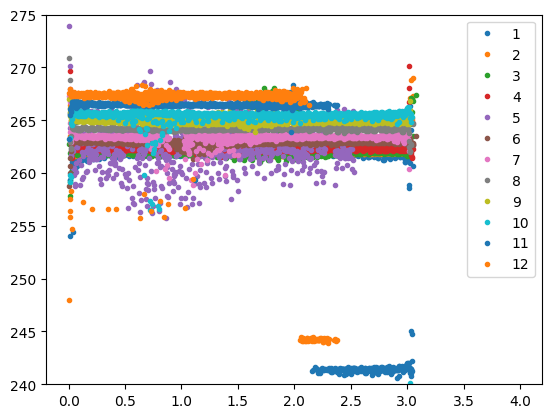

In [384]:
nharms = 12
_ = plt.plot(frmTime[:nfrm], hfreq[:nfrm, np.arange(nharms)] / (np.arange(nharms) + 1)[np.newaxis, :], '.')
plt.ylim([240, 275])
plt.legend(np.arange(nharms) + 1)

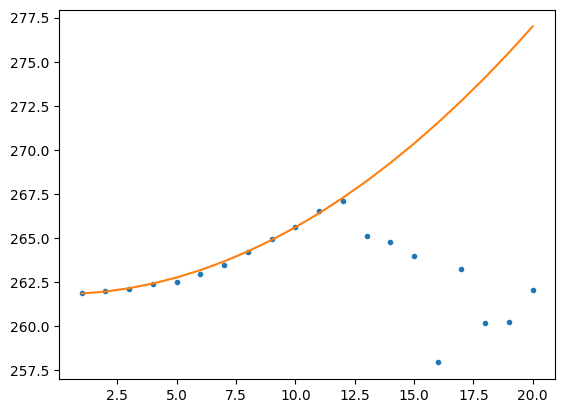

In [400]:
nharms = 20
lfrm = 20
hfrm = 120
_ = plt.plot(np.arange(nharms) + 1, np.mean(hfreq[lfrm:hfrm, np.arange(nharms)] / (np.arange(nharms) + 1)[np.newaxis, :], axis=0), '.')
hnums = np.arange(nharms) + 1
# Slight quadratic term to harmonic frequencies
_ = plt.plot(hnums, 261.8 + 0.038 * hnums*hnums)